# 1. Predicting Change in Sentiments

The goal of this section is to predict the change in the sentiment given the current utterance and the sentiment of the previous utterance. The inputs of the prediction model are the utterance, encoded in a vector of real numbers, and the previous utterance sentiment, a real number between -1 and 1.

To encode the current utterance, I used a 50-dimensional GloVe vector for each word in the message. I then computed the average of all the word vectors for the utterance to produce a 50-dimensional feature vector for the utterance. 
The input of the model has 51 features in total: 50 features for the utterance and 1 features for the previous sentiment. The output of the model is a real number between -2 and +2 which is the difference between the current sentiment and the previous one. 

For my model I used model linear regression, support vector regression, random forest and a recurrent neural network. 

## 1.1 Metric of Evaluation
I used mean square error and r-squared to compare the performaces of different models.

## 1.2 Models

### 1.2.1 Linear Regression
I trained a linear regression model with all the 51 features and recorded the mean square error and r-squared score for the test set. Looking at the coefficients of the features, I can see that the feature for the previous sentiment has a very large positive coefficient (~0.9) while the other features have a small coefficient (~0.0). It seems that the model is only looking at the previous sentiment's feature to predict the change in the sentiment while ignoring the incoming message's features. The r-squared score is low for the training error which means this model is too simple to learn from the input features.

### 1.2.2 Linear Regression with Principal Component Analysis
In the next experiment, I used principal component analysis to reduce the number of features from 51 to 34 while keeping 95 percent of the variance. However, I did not observe any increase or decrease in the performance of the linear regression model. 

### 1.2.3 Linear Regression with L1 Regularization 
In the next experiment, I used L1 regularization to reduce the number of features. However, I did not observe any increase or decrease in the performance of the linear regression model. 

### 1.2.4 Linear Regression with Downsampling 
The distribution of the training samples shows that class labels are unbalanced and more than 8K samples in the training set of ~67K samples have an class label of zero (no change in emotions). Therefore, I downsampled the training samples with the label of 0 from ~8K samples to ~1K samples. This downsampling of train dataset, however, did not change the performance of the linear regression model on the test set.

### 1.2.5 Support Vector Regression
I was not able to train a support vector regression( SVR) for this dataset even with a reduced number of features. The problem is the size of the dataset that is too large for SVR and SVR does not scale well with the size of data. I ran this model for 16 hours on my laptop with no success. 

### 1.2.6 Random Foreset Regression
I trained a random forest with with all the 51 features. The model has a high R-squared value of 0.91 on the training set but a much smaller value of 0.58 on the test set. This difference means that the model is overfitting the training set. The overfitting problem could be resolved by tunning the hyper-parameters of the model. For example, adding more estimators or decreasing depth of trees could help with overfitting. 

### 1.2.7 Recurrent Neural Network (LSTM)
The LSTM model performance is explained in [LSTM MODEL](question_2_part_b.ipynb)


## 1.3 Results
The results of the models on the training and test sets are shown in the following table. Since the mean square error of the LSTM model is the smallest, I chose it for my final model and I validated the LSTM model with the validation set where the mean square error is 0.017.

model                    | MSE(test) | R^2(test) | MSE(train) | R^2(train)  
-------------------------|-----------|-----------|------------|-----------
 Linear Reg              |   0.08    |   0.46    |   0.08     | 0.46
 Linear Reg (PCA)        |   0.08    |   0.46    |   0.08     | 0.46
 Linear Reg (L_1 Reg)    |   0.08    |   0.46    |   0.08     | 0.46
 Linear Reg Downsampling |   0.09    |   0.45    |   0.09     | 0.49
 Random Forest           |   0.07    |   0.58    |   0.01     | 0.91
 RNN (LSTM)              |   0.017   |   0.87    |   0.009    | 0.92

In [108]:
from utility import *

from sklearn import metrics
from sklearn import svm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV


In [72]:
def sentence_to_avg(sentence, word_to_vec_map):
    '''
    this function creates a vector of 50d for an input sentence
    by average all the word vectors in the sentence
    '''
    sentence = re.sub(r'[^\w\s]', ' ', sentence.strip())  
    words = [i.lower() for i in sentence.strip().split()]
    avg = np.zeros((50,))
    
    if len(words) == 0: 
        print(sentence)
        return None
    
    for w in words:
        vec = word_to_vec_map[w] if w in word_to_vec_map else word_to_vec_map['unk'] 
        avg += vec
    avg = avg / len(words)
        
    return avg

In [73]:
def fit_svm_model(x_train, y_train):
    # train svm
    
    clf = svm.SVR(kernel='linear', C=1000)
    clf.fit(x_train, y_train)
    return clf

In [74]:
def fit_random_forest_model(x_train, y_train):
    # train random forest
    model = RandomForestRegressor(n_estimators=100, random_state=42) 
    model.fit(x_train, y_train)
    return model

In [75]:
def fit_regression_model(x_train, y_train):
    # train linear regression
    
    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)
    return model

In [76]:
def create_features(samples_list):
    '''
    this function creates features for each conversation
    '''
    x, y = [], []
    for sample in samples_list:
        vec = sentence_to_avg(sample['utterance'], word_to_vec_map)
        if vec is None: continue
        
        vec = vec.tolist()
        vec.append(sample['current_emotion'])
        
        x.append(vec)
        y.append(sample['current_emotion'] - sample['prev_emotion'])
    
    return x, y

In [77]:
# load glove.6B 50d
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

In [78]:
# loading train, test and validation sets
train_conversations = load_conversations(category='train')
find_sentiments(train_conversations)

test_conversations = load_conversations(category='test')
find_sentiments(test_conversations)

validation_conversations = load_conversations(category='validation')
find_sentiments(validation_conversations)

In [79]:
train_samples = create_samples(train_conversations)
x_train, y_train = create_features(train_samples)

test_samples = create_samples(test_conversations)
x_test, y_test = create_features(test_samples)

In [80]:
print('Number of training samples: ', len(x_train), len(y_train), 'Number of features: ', len(x_train[0]))

Number of training samples:  76051 76051 Number of features:  51


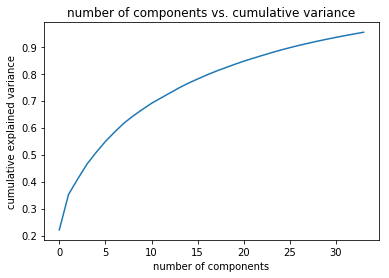

In [96]:
# pca to reduce number of features with a variance = %95
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(x_train)
new_x_train = pca.transform(x_train)   
new_x_test = pca.transform(x_test)    
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("number of components vs. cumulative variance")
plt.show()

In [100]:
# regression model
rgModel = fit_regression_model(x_train, y_train)
print('Coefficients: \n', rgModel.coef_)    

y_pred = rgModel.predict(x_train)
print("Train mean squared error: %.2f"% mean_squared_error(y_train, y_pred))
print('Train variance score: %.2f \n' % r2_score(y_train, y_pred))

y_pred = rgModel.predict(x_test)
print("Test mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Test variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-0.05518255 -0.09586653  0.02818487  0.01035777  0.0116708   0.04732483
  0.00779986  0.06017013  0.02364771  0.00432414 -0.122796    0.09142667
  0.01239393  0.00719745  0.02650578  0.03638743 -0.03397658  0.04212108
 -0.00732165  0.07830698 -0.0605946  -0.00650555 -0.032918    0.01033865
 -0.06733058 -0.00742075  0.01750965  0.02583285  0.02104933  0.03763537
  0.01567542  0.03409339  0.02973543 -0.07539445 -0.00222797 -0.08600382
  0.06424077 -0.00221389  0.02712701  0.07966255  0.03911491  0.01164392
  0.01512918  0.01352975  0.03294507 -0.00647605  0.05839532  0.01001226
  0.01446369 -0.06615325  0.9229181 ]
Train Mean squared error: 0.08
Train Variance score: 0.46 

Test Mean squared error: 0.08
Test Variance score: 0.46


In [102]:
# linear regression with l_1 regularization
regModel_Lasso = linear_model.Lasso(alpha=0.001)
regModel_Lasso.fit(x_train, y_train)
print('Coefficients: \n', regModel_Lasso.coef_) 

y_pred = regModel_Lasso.predict(x_train)
print("Train mean squared error: %.2f"% mean_squared_error(y_train, y_pred))
print('Train variance score: %.2f \n' % r2_score(y_train, y_pred))

y_pred_lasso = regModel_Lasso.predict(x_test)
print("Test mean squared error: %.2f"% mean_squared_error(y_test, y_pred_lasso))
print('Test variance score: %.2f' % r2_score(y_test, y_pred_lasso))

Coefficients: 
 [ 0.00000000e+00 -1.77529914e-02  7.31177687e-04  0.00000000e+00
 -0.00000000e+00  1.72254352e-04  2.62283367e-03  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.93252703e-02 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.42922764e-02  4.88171484e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.14059961e-04 -1.01634703e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.94385506e-02  0.00000000e+00  1.12277663e-03
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  4.48685309e-03
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  6.89713196e-03
  0.00000000e+00  0.00000000e+00  8.85407958e-01]
Train mean squared error: 0.08
Train variance score: 0.46 

Test mean squared error: 0.08
Test variance score: 0.46


In [104]:
# regression model with a reduced number of features
rgModel_PCA = fit_regression_model(new_x_train, y_train)
print('Coefficients: \n', rgModel_PCA.coef_)  

y_pred = rgModel_PCA.predict(new_x_train)
print("Train mean squared error: %.2f"% mean_squared_error(y_train, y_pred))
print('Train variance score: %.2f \n' % r2_score(y_train, y_pred))

y_pred = rgModel_PCA.predict(new_x_test)
print("Test mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Test variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-0.01588763 -0.01961595  0.11603304  0.23784433 -0.21233813 -0.48977211
  0.35331376 -0.09234219 -0.21640386  0.0998127  -0.30396224  0.2075275
  0.07616187 -0.30565344 -0.00909076 -0.01723262 -0.03074026  0.18717432
 -0.07100299 -0.04446019 -0.03955126  0.08211716  0.06333477 -0.04804121
 -0.00297954 -0.02521183 -0.00679153  0.09885389 -0.08641928  0.01576869
  0.01131894  0.03226107 -0.04156359  0.02640871]
Train mean squared error: 0.08
Train variance score: 0.46 

Test mean squared error: 0.08
Test variance score: 0.46


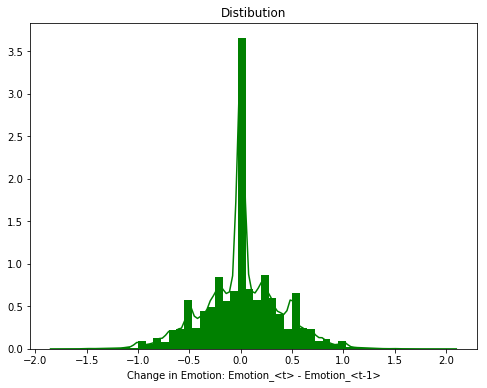

In [51]:
# distribution of change in emotion
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_train, kde=True, color='green', hist_kws=dict(alpha=1))
plt.xlabel('Change in Emotion: Emotion_<t> - Emotion_<t-1>')
plt.title('Disribution of Outcome')
plt.show()

In [ ]:
# downsample majority output: emotion=0
data = {}
data['input'] = x_train
data['output'] = y_train
data_df = pd.DataFrame(data)

label_25 = data_df[data_df.output == 0.25]
non_zero_label = data_df[data_df.output != 0]
zero_label = data_df[data_df.output == 0]

# Downsample majority label: emotion=0.0
df_zeros_downsampled = resample(zero_label, 
                               replace=False,    # sample without replacement
                               n_samples=label_25.count()[0],     # to match minority class
                               random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_zeros_downsampled, non_zero_label])
 

In [105]:
# display new class counts
print("Downsampled: ", df_downsampled.count())

downsampled_y_train = df_downsampled['output']
downsampled_x_train = df_downsampled['input']

downsampled_x_train = downsampled_x_train.values.tolist()

# regression model after downsampling
rgModel = linear_model.LinearRegression()
rgModel.fit(downsampled_x_train, downsampled_y_train)

print('Coefficients: \n', rgModel.coef_)   

y_pred = rgModel.predict(downsampled_x_train)
print("Train mean squared error: %.2f"% mean_squared_error(downsampled_y_train, y_pred))
print('Train variance score: %.2f \n' % r2_score(downsampled_y_train, y_pred))

y_pred = rgModel.predict(x_test)
print("Test mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Test variance score: %.2f' % r2_score(y_test, y_pred))

Downsampled:  input     58501
output    58501
dtype: int64
Coefficients: 
 [-0.08313461 -0.14098571 -0.01609979 -0.0042521   0.03715972  0.04615805
  0.02822943  0.07511453  0.04154947  0.03692298 -0.17593751  0.08199837
 -0.07360039  0.00291884 -0.03698849  0.06862022 -0.09157225  0.07004675
 -0.02978599  0.13050075 -0.08057468 -0.07773773 -0.03190529  0.02704783
 -0.01083884  0.04302959  0.04119686  0.04029173  0.05226092  0.06125555
  0.04468681  0.04546069  0.02474527 -0.11195073  0.01221713 -0.09152922
  0.09014953 -0.03388063  0.04843823  0.01421851  0.04377269  0.07616073
  0.07685781  0.05208835  0.0668411  -0.04680021  0.00273032  0.01504504
 -0.02617958 -0.08306238  0.99428566]
Train mean squared error: 0.09
Train variance score: 0.49 

Test mean squared error: 0.09
Test variance score: 0.45


In [114]:
# random forest with 51 features
rfModel = RandomForestRegressor(max_depth=70, n_estimators=400)

rfModel.fit(x_train, y_train)
y_pred = rfModel.predict(x_train)   
print("Train mean squared error: %.2f"% mean_squared_error(y_train, y_pred))
print('Train variance score: %.2f \n' % r2_score(y_train, y_pred))

y_pred = rfModel.predict(x_test)   
print("Test mean squared error: %.2f"% mean_squared_error(y_test, y_pred))
print('Test variance score: %.2f' % r2_score(y_test, y_pred))

Train mean squared error: 0.01
Train variance score: 0.91 

Test mean squared error: 0.07
Test variance score: 0.58


In [111]:
# hyper parameter search for random forest
rfModel = RandomForestRegressor() 

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfModel, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)
best_grid = grid_search.best_estimator_
best_grid

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  32.9s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  32.8s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  33.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  boots

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.3min


[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total= 1.9min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, total= 1.9min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 6.3min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 6.4min
[CV] bootstrap=True, max_depth=80, max_feature

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total= 1.8min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total= 1.8min
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total= 6.3min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV] bootstrap=True, max_depth=80, max_features=2, min_sam

KeyboardInterrupt: 

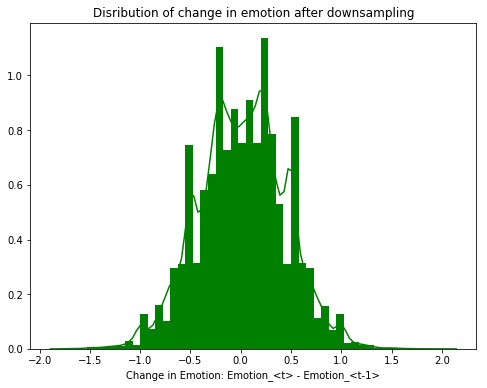

In [69]:
# distribution of change in emotion after downsampling zeros
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(downsampled_y_train, kde=True, color='green', hist_kws=dict(alpha=1))
plt.xlabel('Change in Emotion: Emotion_<t> - Emotion_<t-1>')
plt.title('Disribution of change in emotion after downsampling')
plt.show()

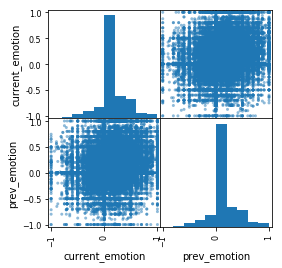

In [94]:
# distribution of 
emotions_df = pd.DataFrame(train_samples)
pd.plotting.scatter_matrix(emotions_df, figsize=(4, 4))
# plt.title('distribution of emotions')
plt.show()